In [1]:
from itertools import combinations, product
import math

import tskit
import msprime
import numpy as np

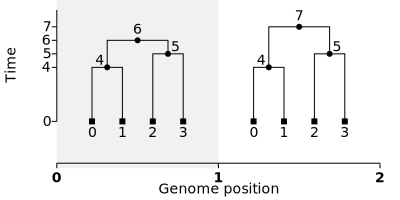

In [40]:
import io
import tskit

nodes = """\
is_sample time
1         0
1         0
1         0
1         0
1         0
0         2
0         3
0         4
0         6
0         7
"""

edges = """\
left   right   parent  child
0      20      5       0,1
0      10      6       3,4
0      20      7       5,2
0      10      9       7,6
10     20      8       7,3
10     20      9       8,4
"""

nodes = """\
is_sample time
1         0
1         0
1         0
1         0
0         4
0         5
0         6
0         7
"""
edges = """\
left   right   parent  child
0      2       4       0,1
0      2       5       2,3
0      1       6       4,5
1      2       7       4,5
"""

# sites = """\
# position ancestral_state
# """

# mutations = """\
# site node parent derived_state
# """

ts = tskit.load_text(
    nodes=io.StringIO(nodes),
    edges=io.StringIO(edges),
    # sites=io.StringIO(sites),
    # mutations=io.StringIO(mutations),
    strict=False,
)

ts.draw_svg(y_axis=True)

In [52]:
x = ts.at_index(0)
y = ts.at_index(1)
ij, ijk, ijkl = combine(ts.samples())
# stats.append(compute_D2(ts, x, y, ij, ijk, ijkl, mu=2e-8))
compute_D2(ts, x, y, ij, ijk, ijkl, mu=1), compute_Dz(x, y, ijk, ijkl, mu=1), compute_pi2(x, y, ijkl, mu=1)

(4236067.296980768, 40051916.98423794, 49274798.26322764)

In [53]:
compute_D2(ts, x, y, ij, ijk, ijkl)

4236067.296980768

In [57]:
compute_pi2(x, y, ijkl, mu=1)

49274798.26322764

In [56]:
np.mean([x.tmrca(i, j) * y.tmrca(k, l) for i, j, k, l in ijkl])

49274798.26322764

In [38]:
compute_D2(ts, ts.at_index(0), ts.at_index(1), ij, ijk, ijkl)

T 330.0
E 33.0 30.566666666666666 30.533333333333335


2.400000000000002

In [34]:
compute_D2_I(ts, x, y, ij, ijk, ijkl)

T 339.0
E 5.9 1.3 2.933333333333333


6.233333333333333

In [26]:
combine(range(4))[1]

[(0, 1, 2),
 (0, 1, 3),
 (0, 2, 1),
 (0, 2, 3),
 (0, 3, 1),
 (0, 3, 2),
 (1, 0, 2),
 (1, 0, 3),
 (1, 2, 0),
 (1, 2, 3),
 (1, 3, 0),
 (1, 3, 2),
 (2, 0, 1),
 (2, 0, 3),
 (2, 1, 0),
 (2, 1, 3),
 (2, 3, 0),
 (2, 3, 1),
 (3, 0, 1),
 (3, 0, 2),
 (3, 1, 0),
 (3, 1, 2),
 (3, 2, 0),
 (3, 2, 1)]

In [3]:
def combine(samples):
    ij = list(combinations(samples, 2))
    ijk = [(i, j, k) for i, j, k in product(samples, repeat=3)
           if i != k and i != j and j != k]
    ijkl = [(i, j, k, l) for i, j in combinations(samples, 2)
            for k in range(len(samples))
            for l in range(k + 1, len(samples))
            if i != k and j != k and l != i and l != j]
    return ij, ijk, ijkl

In [43]:
def compute_D2(ts, x, y, ij, ijk, ijkl, norm=False, mu=None):
    E_ijij = np.mean([x.tmrca(i, j) * y.tmrca(i, j) for i, j in ij]) 
    E_ijik = np.mean([x.tmrca(i, j) * y.tmrca(i, k) for i, j, k in ijk])
    E_ijkl = np.mean([x.tmrca(i, j) * y.tmrca(k, l) for i, j, k, l in ijkl])
    # print('T', sum([x.tmrca(i, j) * y.tmrca(i, j) for i, j in ij]))
    # print('E', E_ijij, E_ijik, E_ijkl)
    D2 = E_ijij - 2 * E_ijik + E_ijkl
    if norm:
        T_xy = ts.get_time(x.root) * ts.get_time(y.root)
        return D2 / T_xy
    elif mu:
        return D2 * (mu ** 2)
    return D2

In [18]:
def compute_D2_I(ts, x, y, ij, ijk, ijkl, norm=False, mu=None):
    T_x = ts.tables.nodes.time[x.root]
    T_y = ts.tables.nodes.time[y.root]
    E_ijij = np.mean([(T_x - x.tmrca(i, j)) * (T_y - y.tmrca(i, j)) for i, j in ij]) 
    E_ijik = np.mean([(T_x - x.tmrca(i, j)) * (T_y - y.tmrca(i, k)) for i, j, k in ijk])
    E_ijkl = np.mean([(T_x - x.tmrca(i, j)) * (T_y - y.tmrca(k, l)) for i, j, k, l in ijkl])
    print('T', sum([x.tmrca(i, j) * y.tmrca(i, j) for i, j in ij]))
    print('E', E_ijij, E_ijik, E_ijkl)
    D2 = E_ijij - 2 * E_ijik + E_ijkl
    if norm:
        T_xy = ts.get_time(x.root) * ts.get_time(y.root)
        return D2 / T_xy
    elif mu:
        return D2 * (mu ** 2)
    return D2

In [49]:
def compute_pi2(x, y, ijkl, mu):
    E_ijkl = np.mean([x.tmrca(i, j) * y.tmrca(k, l) for i, j, k, l in ijkl])
    return E_ijkl * (mu ** 2)

In [6]:
def compute_Dz(x, y, ijk, ijkl, mu):
    E_ijik = np.mean([x.tmrca(i, j) * y.tmrca(i, k) for i, j, k in ijk])
    E_ijkl = np.mean([x.tmrca(i, j) * y.tmrca(k, l) for i, j, k, l in ijkl])
    return 4 * (E_ijik - E_ijkl) * (mu ** 2)

In [ ]:
def ld_matrix_branch(pos):
    for 

In [46]:
while True:
    tss = msprime.sim_ancestry(
        samples=2,
        population_size=10_000,
        recombination_rate=5e-4,
        sequence_length=2,
        # random_seed=123,
        num_replicates=1_000_000,
        # num_replicates=100_000,
    )
    stats = []
    for ts in tss:
        if ts.num_trees != 2:
            continue
        x = ts.at_index(0)
        y = ts.at_index(1)
        ij, ijk, ijkl = combine(ts.samples())
        # stats.append(compute_D2(ts, x, y, ij, ijk, ijkl, mu=2e-8))
        stats.append([
            compute_D2(ts, x, y, ij, ijk, ijkl, mu=2e-8),
            compute_Dz(x, y, ijk, ijkl, mu=2e-8),
            compute_pi2(x, y, ijkl, mu=2e-8)
        ])
    print(np.mean(stats, 0))

[7.06553131e-09 1.85878032e-09 1.61133246e-07]
[7.09357418e-09 1.88674227e-09 1.61066552e-07]
[6.97829797e-09 2.29045879e-09 1.61044887e-07]
[7.11350386e-09 1.81144869e-09 1.61089826e-07]
[7.09954952e-09 1.55200385e-09 1.61082243e-07]
[7.13260564e-09 2.05147532e-09 1.61086143e-07]
[7.04682312e-09 1.83031389e-09 1.61233355e-07]
[6.98053033e-09 2.14491890e-09 1.61161069e-07]
[7.10697794e-09 1.99953618e-09 1.61052495e-07]
[7.01025189e-09 2.02500391e-09 1.61011647e-07]
[7.16727322e-09 1.54750461e-09 1.61383448e-07]
[7.02088142e-09 1.82693923e-09 1.60864015e-07]
[7.02198264e-09 1.94351103e-09 1.60920020e-07]
[7.09254491e-09 1.96663023e-09 1.60860867e-07]
[7.18101638e-09 1.71696209e-09 1.60926565e-07]
[7.03008572e-09 1.94535786e-09 1.61098467e-07]
[7.11115784e-09 1.72659917e-09 1.61102882e-07]
[7.12525984e-09 1.58110805e-09 1.61190934e-07]
[7.03413492e-09 2.06483629e-09 1.60999271e-07]
[7.11853573e-09 1.81143110e-09 1.61279035e-07]
[6.99920660e-09 2.09422463e-09 1.61179946e-07]
[6.96631027e-

KeyboardInterrupt: 

In [29]:
ijkl

[(0, 1, 2, 3),
 (0, 2, 1, 3),
 (0, 3, 1, 2),
 (1, 2, 0, 3),
 (1, 3, 0, 2),
 (2, 3, 0, 1)]